In [29]:
from datagen import load
from sklearn.neighbors import radius_neighbors_graph
import numpy as np
from spectral_mix import SpectralMix
import time
from sklearn.metrics import normalized_mutual_info_score, adjusted_rand_score
import pandas as pd
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

In [25]:
test_params = [
    {
        'dataset_name': 'mnist',
        'epsilon': 1500
    },
    {
        'dataset_name': 'snap',
        'epsilon': None
    }
]

In [28]:
test_results = pd.DataFrame(columns=['dataset', 'nmi', 'ari', 'runtime', 'd', 'iter'])
for test in test_params:
    dataset = test['dataset_name']
    eps = test['epsilon']
    print(f'=== {dataset} ===')

    if eps is None:
        W, y_true = load(dataset)
        np.fill_diagonal(W, 1)
    else:
        X, y_true = load(dataset)
        W = radius_neighbors_graph(X, radius=eps, mode='connectivity', include_self=True)
        W = W.toarray()

    W = W.reshape((W.shape[0], W.shape[0], 1))

    clusters = np.unique(y_true)
    k = len(clusters)

    for it in [50, 100, 200]:
        print(f'    iter={it}')
        for d in [2, 4, 8, 10]:
            print(f'        d={d}')

            sm = SpectralMix(d=d, n_clusters=k, iter=it)
            begin = time.time()
            sm.fit(adjacency_matrix=W, attribute_matrix=None)
            end = time.time()

            # save labels and embedding
            labels = sm.predict()
            o = sm.o
            np.save(f'clusterings/o_{dataset}_d{d}_iter{it}.npy', o)
            np.save(f'clusterings/labels_{dataset}_d{d}_iter{it}.npy', labels)

            nmi = normalized_mutual_info_score(y_true, labels)
            ari = adjusted_rand_score(y_true, labels)

            # save results
            result = []
            result.append(dataset)
            result.append(nmi)
            result.append(ari)
            result.append(end - begin)
            result.append(d)
            result.append(it)
            test_results.loc[len(test_results)] = result
            test_results.to_csv('test_results/comparison_test.csv')

=== mnist ===
    iter=50
        d=2


100%|██████████| 50/50 [00:12<00:00,  4.12it/s]


        d=4


100%|██████████| 50/50 [00:24<00:00,  2.02it/s]


        d=8


100%|██████████| 50/50 [00:52<00:00,  1.05s/it]


        d=10


100%|██████████| 50/50 [01:02<00:00,  1.25s/it]


    iter=100
        d=2


100%|██████████| 100/100 [00:24<00:00,  4.08it/s]


        d=4


100%|██████████| 100/100 [00:44<00:00,  2.22it/s]


        d=8


100%|██████████| 100/100 [01:41<00:00,  1.01s/it]


        d=10


100%|██████████| 100/100 [02:10<00:00,  1.31s/it]


    iter=200
        d=2


100%|██████████| 200/200 [00:53<00:00,  3.73it/s]


        d=4


100%|██████████| 200/200 [01:34<00:00,  2.11it/s]


        d=8


100%|██████████| 200/200 [03:38<00:00,  1.09s/it]


        d=10


100%|██████████| 200/200 [05:06<00:00,  1.53s/it]


=== snap ===
    iter=50
        d=2


100%|██████████| 50/50 [00:00<00:00, 75.62it/s]


        d=4


100%|██████████| 50/50 [00:01<00:00, 44.27it/s]


        d=8


100%|██████████| 50/50 [00:02<00:00, 24.13it/s]


        d=10


100%|██████████| 50/50 [00:03<00:00, 15.45it/s]


    iter=100
        d=2


100%|██████████| 100/100 [00:01<00:00, 78.46it/s]


        d=4


100%|██████████| 100/100 [00:02<00:00, 49.39it/s]


        d=8


100%|██████████| 100/100 [00:03<00:00, 27.18it/s]


        d=10


100%|██████████| 100/100 [00:06<00:00, 15.14it/s]


    iter=200
        d=2


100%|██████████| 200/200 [00:02<00:00, 79.10it/s]


        d=4


100%|██████████| 200/200 [00:04<00:00, 42.48it/s]


        d=8


100%|██████████| 200/200 [00:07<00:00, 25.09it/s]


        d=10


100%|██████████| 200/200 [00:10<00:00, 19.11it/s]


In [30]:
def plot_scatter(data, labels, dataset_name, subtitle, dim):
    _, ax = plt.subplots(figsize=(6, 6))
    ax.scatter(data[:, 0], data[:, 1], c=labels, s=2)
    
    ax.grid()
    ax.set_title(f'Node Embedding Computed by SpectralMix for Dataset {dataset_name}\n{subtitle}')
    ax.set_xlabel('X')
    ax.set_ylabel('Y')

    plt.savefig(f'plots/comp_scatterplots/{dataset_name}_clustering_d{dim}_{subtitle.replace(' ', '_')}.png')
    plt.show()

=== Plotting mnist ===


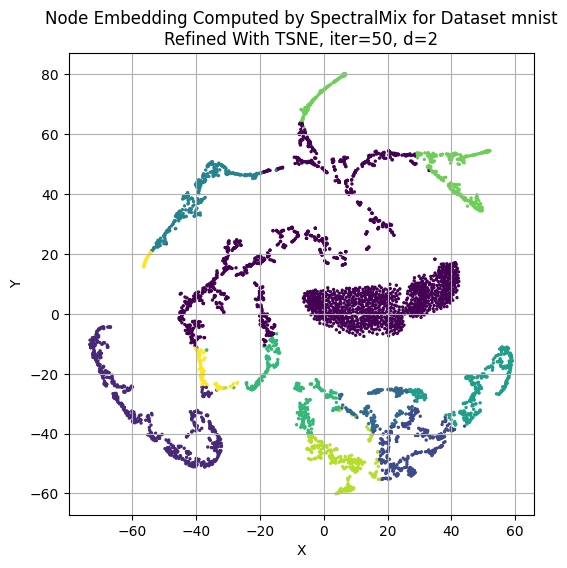

ValueError: 'c' argument has 1005 elements, which is inconsistent with 'x' and 'y' with size 5000.

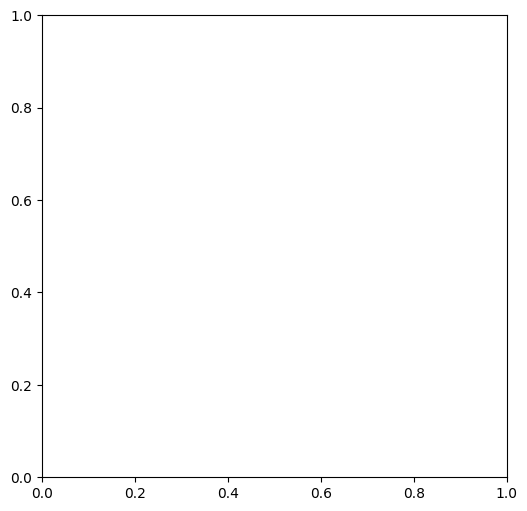

In [32]:
for test in test_params:
    dataset = test['dataset_name']
    _, y_true = load(dataset)

    print(f'=== Plotting {dataset} ===')
    for it in [50, 100, 200]:
        for d in [2, 4, 8, 10]:

            o = np.load(f'clusterings/o_{dataset}_d{d}_iter{it}.npy')
            labels = np.load(f'clusterings/labels_{dataset}_d{d}_iter{it}.npy')

            o = TSNE(n_components=2).fit_transform(o)

            subtitle = f'Refined With TSNE, iter={it}, d={d}'

            plot_scatter(o, labels, dataset, subtitle, d)
            plot_scatter(o, y_true, dataset, subtitle + ', true labels', d)